In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
import glob

In [28]:
csv_files = glob.glob('stock-time-series-20050101-to-20171231/*.csv')
df_list = [pd.read_csv(file) for file in csv_files]
combined_df = pd.concat(df_list, ignore_index=True)

In [29]:
common_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
df_list = [pd.read_csv(file)[common_columns] for file in csv_files]

In [30]:
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df = combined_df.sort_values('Date').reset_index(drop=True)

In [31]:
combined_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195005 entries, 0 to 195004
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    195005 non-null  datetime64[ns]
 1   Open    194931 non-null  float64       
 2   High    194976 non-null  float64       
 3   Low     194946 non-null  float64       
 4   Close   195005 non-null  float64       
 5   Volume  195005 non-null  int64         
 6   Name    195005 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 10.4+ MB


In [34]:
combined_df.ffill(inplace=True)
#combined_df.isnull().sum()


In [33]:
combined_df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
1,2006-01-03,126.70,129.44,124.23,128.87,6188700,GS
2,2006-01-03,17.21,17.49,17.18,17.45,55432166,CSCO
3,2006-01-03,40.39,41.45,39.77,41.24,8960100,HD
4,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM


In [37]:
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

In [38]:
combined_df.head()

,Date,Open,High,Low,Close,Volume,Name,Year,Month,Day
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA,2006,1,3
1,2006-01-03,126.70,129.44,124.23,128.87,6188700,GS,2006,1,3
2,2006-01-03,17.21,17.49,17.18,17.45,55432166,CSCO,2006,1,3
3,2006-01-03,40.39,41.45,39.77,41.24,8960100,HD,2006,1,3
4,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM,2006,1,3


In [43]:
#sns.lineplot(data=combined_df, x='Date', y='Close')
#plt.title('Stock Closing Prices Over Time')

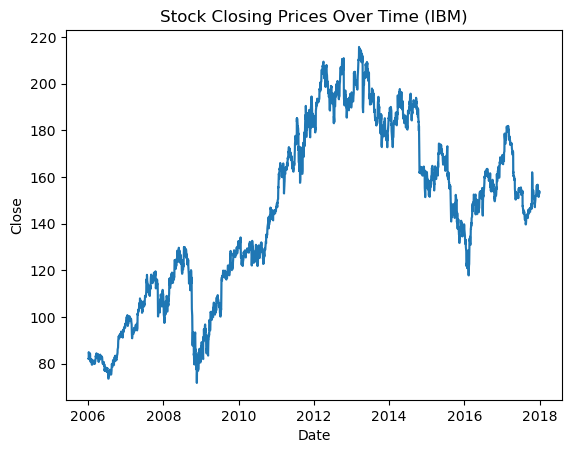

In [41]:
sns.lineplot(data=combined_df[combined_df['Name'] == 'IBM'], x='Date', y='Close')
plt.title('Stock Closing Prices Over Time (IBM)')
plt.show()